# **Tomato OR Apple Classifier**

In [52]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline

## **Data Processing** 

In [37]:
transform = transforms.Compose(
    [
        transforms.Resize((100,100)), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [25]:
#labels : dict = {"apples" : 0, "tomatoes" : 1}

In [26]:
'''
train_data : list = []
test_data : list = []

for i in os.listdir("/kaggle/input/apples-or-tomatoes-image-classification"):
    i = os.path.join("/kaggle/input/apples-or-tomatoes-image-classification", i)
    for j in os.listdir(i):
        for k in os.listdir(os.path.join(i, j)):
            
            if i.endswith("train"):
                train_data.append(
                    [
                        cv2.imread(os.path.join(os.path.join(i, j), k)), 
                        labels[j]
                    ]
                )
            
            else:
                test_data.append(
                    [
                        cv2.imread(os.path.join(os.path.join(i, j), k)), 
                        labels[j]
                    ]
                )
'''

'\ntrain_data : list = []\ntest_data : list = []\n\nfor i in os.listdir("/kaggle/input/apples-or-tomatoes-image-classification"):\n    i = os.path.join("/kaggle/input/apples-or-tomatoes-image-classification", i)\n    for j in os.listdir(i):\n        for k in os.listdir(os.path.join(i, j)):\n            \n            if i.endswith("train"):\n                train_data.append(\n                    [\n                        cv2.imread(os.path.join(os.path.join(i, j), k)), \n                        labels[j]\n                    ]\n                )\n            \n            else:\n                test_data.append(\n                    [\n                        cv2.imread(os.path.join(os.path.join(i, j), k)), \n                        labels[j]\n                    ]\n                )\n'

In [38]:
train_data = datasets.ImageFolder(
    "/kaggle/input/apples-or-tomatoes-image-classification/train", 
    transform = transform
)

test_data = datasets.ImageFolder(
    "/kaggle/input/apples-or-tomatoes-image-classification/test", 
    transform = transform
)

In [39]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

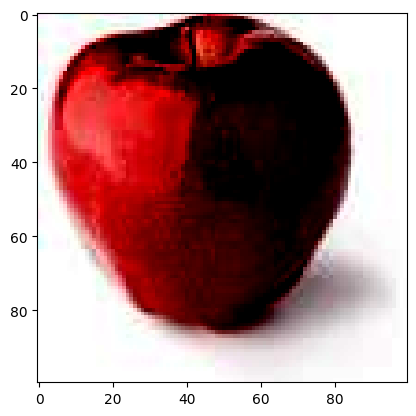

In [49]:
plt.imshow(train_loader.dataset[0][0].detach().numpy().transpose((1, 2, 0)))

## **Testing Convolution And Pooling Layers**

In [56]:
conv1 = nn.Conv2d(3, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

X = F.relu(conv1(train_loader.dataset[0][0]))
X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
X = F.max_pool2d(X, 2, 2)

In [57]:
X.shape

torch.Size([16, 23, 23])

In [60]:
fig = plt.figure(figsize = (100, 100))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(X[i].detach().numpy())
    plt.title("Label {i + 1}")

## **Creating The Model**

In [63]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(6, 16, 3, 1),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 23 * 23, 120), 
            nn.Linear(120, 84), 
            nn.Linear(84, 56), 
            nn.Linear(56, 56), 
            nn.Linear(56, 2)
        )
    
    def forward(self, X):
        X = self.feature_extraction(X)
        X = X.view(-1, 16 * 23 * 23)
        X = self.fc_layers(X)
        
        return F.log_softmax(X, dim = 1)

In [103]:
Model = CNN()

In [104]:
Model

CNN(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8464, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=56, bias=True)
    (3): Linear(in_features=56, out_features=56, bias=True)
    (4): Linear(in_features=56, out_features=2, bias=True)
  )
)

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001)

## **Training The Model**

In [115]:
if __name__ == "__main__":
    for epoch in range(100):
        for b, (X, y) in enumerate(train_loader.dataset):
            y_pred = Model(X)
            loss = criterion(y_pred, torch.LongTensor([y]))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (b + 1) % 100 == 0:
                print(f"Epoch : {epoch + 1}, Batch : {b + 1}, loss : {loss.item()}")

Epoch : 1, Batch : 100, loss : 0.03723685443401337
Epoch : 1, Batch : 200, loss : 0.6624402403831482
Epoch : 2, Batch : 100, loss : 0.4470332860946655
Epoch : 2, Batch : 200, loss : 1.0544496774673462
Epoch : 3, Batch : 100, loss : 0.0
Epoch : 3, Batch : 200, loss : 0.038314733654260635
Epoch : 4, Batch : 100, loss : 0.1024843230843544
Epoch : 4, Batch : 200, loss : 0.7868838310241699
Epoch : 5, Batch : 100, loss : 0.2904844880104065
Epoch : 5, Batch : 200, loss : 0.6601842045783997
Epoch : 6, Batch : 100, loss : 0.032862354069948196
Epoch : 6, Batch : 200, loss : 0.6271789073944092
Epoch : 7, Batch : 100, loss : 0.5169549584388733
Epoch : 7, Batch : 200, loss : 0.8346747159957886
Epoch : 8, Batch : 100, loss : 0.4454568326473236
Epoch : 8, Batch : 200, loss : 0.7945538759231567
Epoch : 9, Batch : 100, loss : 0.6283298134803772
Epoch : 9, Batch : 200, loss : 0.8310220241546631
Epoch : 10, Batch : 100, loss : 0.6083231568336487
Epoch : 10, Batch : 200, loss : 0.8404316902160645
Epoch : 

## **Accuracy Of The Model**

In [122]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader.dataset:
    y_pred = Model(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct += (predicted == y_test).sum()

In [123]:
# Accuracy
print(f"Accuracy : {correct.item() / len(test_data) * 100}%")

Accuracy : 68.04123711340206%


## **Saving The Model** 

In [125]:
torch.save(Model.state_dict(), "TomatoORApple_CNN_Model.pt")